# ターゲット変数の詳細分析

**目的**: 目的変数（money_room）の分布、特性、特徴量との関係を深く理解する

**このノートブックで行うこと**:
1. ターゲット変数の基本統計量
2. 分布の可視化（ヒストグラム、箱ひげ図、QQプロット）
3. 外れ値の検出と分析
4. 時系列トレンドの確認
5. 主要特徴量との関係性
6. カテゴリ別のターゲット分布

## セットアップ

In [ ]:
import sys
import os
from pathlib import Path
import warnings

# ワーニングを非表示
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# 作業ディレクトリをプロジェクトルートに変更
os.chdir(project_root)

import polars as pl
import numpy as np

# matplotlibのバックエンドを先に設定（高速化）
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# スタイルを先に設定（フォント設定の前に）
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# 日本語フォント設定
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    # japanize-matplotlibがない場合はデフォルトフォント
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']

# マイナス記号の文字化け対策
plt.rcParams['axes.unicode_minus'] = False

# 自作モジュール
from src.data.loader import DataLoader
from src.utils.config import load_config
from src.eda.profiler import get_numerical_summary
from src.eda.visualizer import (
    plot_distribution,
    plot_target_vs_feature,
    plot_time_series,
)

%matplotlib inline

# Polars設定
pl.Config.set_tbl_rows(20)

print("✓ セットアップ完了")
print(f"  プロジェクトルート: {project_root.name}/")
print(f"  使用フォント: {plt.rcParams['font.sans-serif'][0]}")

## 1. データ読み込み

In [2]:
# データ読み込み
data_config = load_config("data")
loader = DataLoader(data_config)
train = loader.load_train()

# ターゲット変数の存在確認
target_col = "money_room"
assert target_col in train.columns, f"ターゲット変数 '{target_col}' が見つかりません"

print(f"訓練データ: {train.shape}")
print(f"ターゲット変数: {target_col}")

訓練データ: (363924, 149)
ターゲット変数: money_room


## 2. ターゲット変数の基本統計量

In [3]:
# 基本統計量
target_stats = train.select(pl.col(target_col)).describe()
print("[ターゲット変数の統計量]")
print(target_stats)

[ターゲット変数の統計量]
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ money_room │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 363924.0   │
│ null_count ┆ 0.0        │
│ mean       ┆ 2.5925e7   │
│ std        ┆ 1.8573e7   │
│ min        ┆ 4.9e6      │
│ 25%        ┆ 1.399e7    │
│ 50%        ┆ 2.18e7     │
│ 75%        ┆ 3.23e7     │
│ max        ┆ 1.88e8     │
└────────────┴────────────┘


In [4]:
# 欠損値の確認
null_count = train[target_col].null_count()
null_ratio = null_count / train.height

print(f"\n[欠損値情報]")
print(f"欠損値数: {null_count}")
print(f"欠損割合: {null_ratio:.2%}")


[欠損値情報]
欠損値数: 0
欠損割合: 0.00%


In [5]:
# 追加の統計量（歪度、尖度）
target_values = train[target_col].drop_nulls().to_numpy()

print(f"\n[分布の形状]")
print(f"歪度（Skewness）: {stats.skew(target_values):.4f}")
print(f"尖度（Kurtosis）: {stats.kurtosis(target_values):.4f}")
print(f"\n※ 歪度 > 0: 右に裾が長い、歪度 < 0: 左に裾が長い")
print(f"※ 尖度 > 0: 正規分布より尖っている、尖度 < 0: 正規分布より平ら")


[分布の形状]
歪度（Skewness）: 2.7559
尖度（Kurtosis）: 12.8050

※ 歪度 > 0: 右に裾が長い、歪度 < 0: 左に裾が長い
※ 尖度 > 0: 正規分布より尖っている、尖度 < 0: 正規分布より平ら


## 3. 分布の可視化

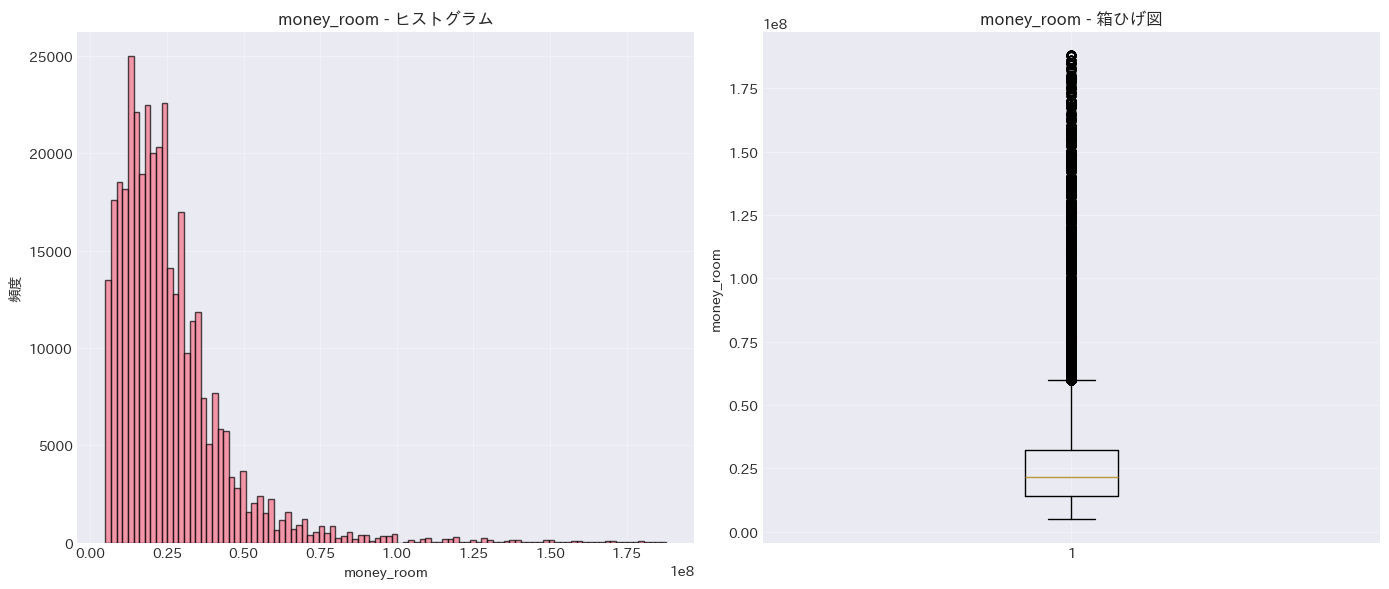

In [6]:
# ヒストグラムと箱ひげ図
plot_distribution(train, target_col, bins=100, figsize=(14, 6))

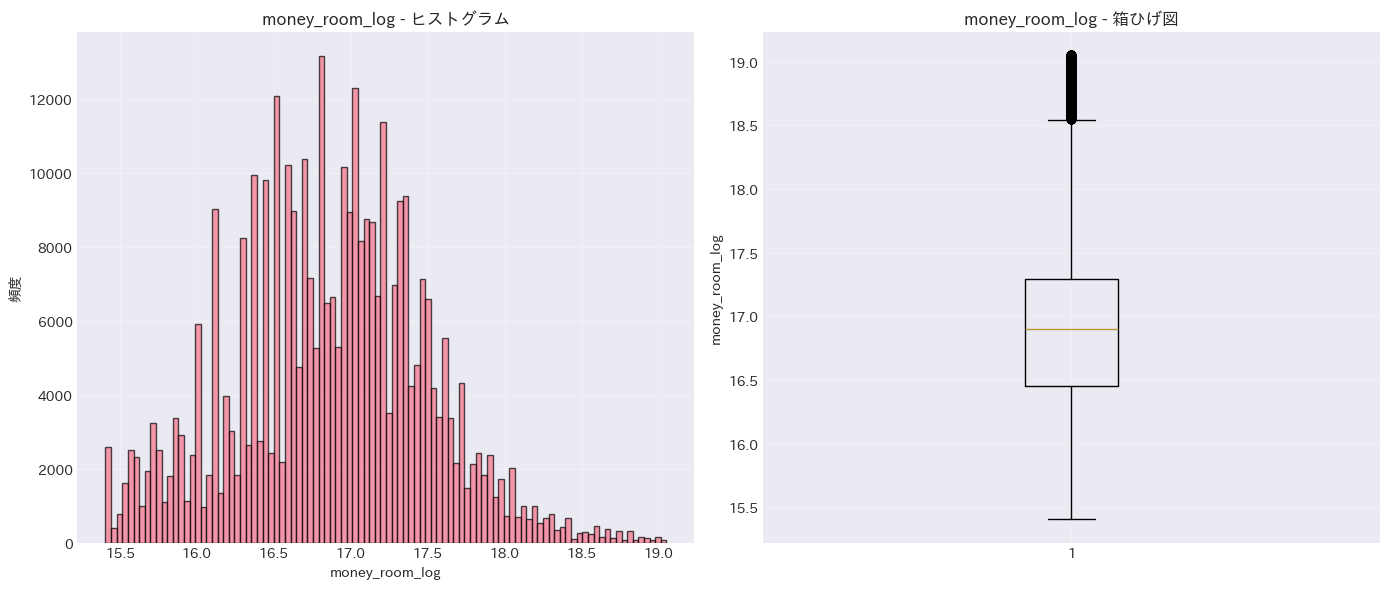

In [7]:
# log変換後の分布
# 回帰問題では対数変換が有効な場合が多い
train_with_log = train.with_columns(
    pl.col(target_col).log().alias(f"{target_col}_log")
)

plot_distribution(train_with_log, f"{target_col}_log", bins=100, figsize=(14, 6))

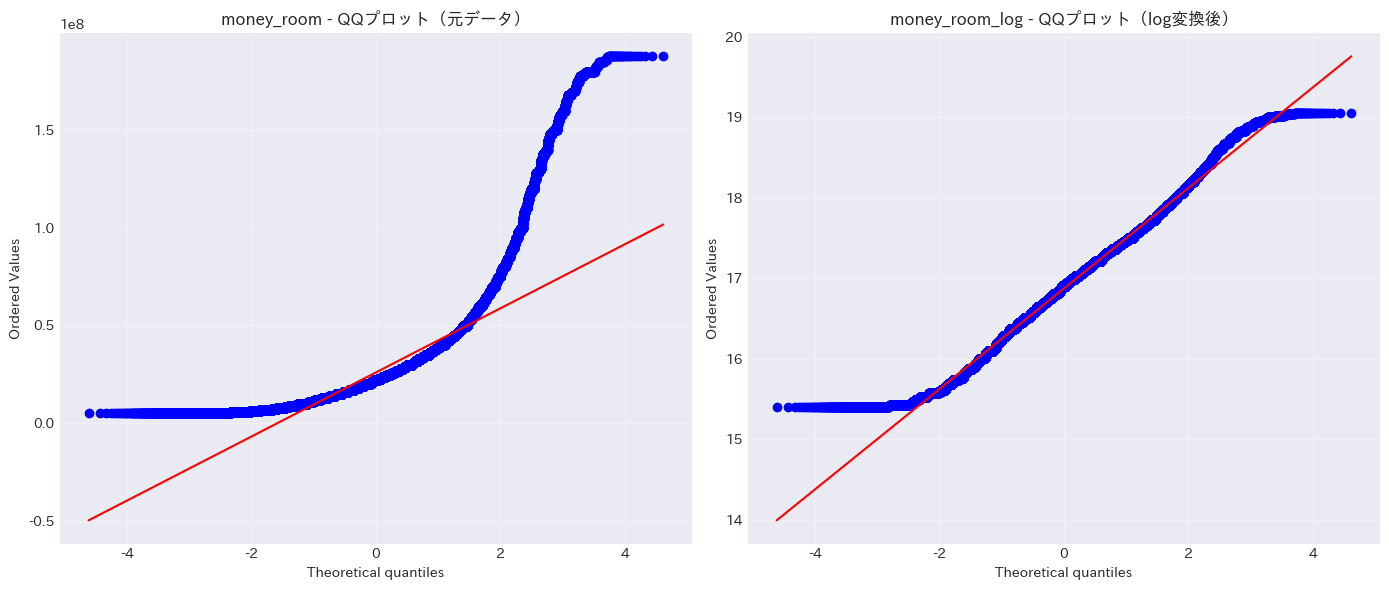

※ 点が直線に乗っていれば正規分布に近い


In [8]:
# QQプロット（正規性の確認）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 元データ
stats.probplot(target_values, dist="norm", plot=axes[0])
axes[0].set_title(f"{target_col} - QQプロット（元データ）")
axes[0].grid(alpha=0.3)

# log変換後
target_log = train_with_log[f"{target_col}_log"].drop_nulls().to_numpy()
stats.probplot(target_log, dist="norm", plot=axes[1])
axes[1].set_title(f"{target_col}_log - QQプロット（log変換後）")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("※ 点が直線に乗っていれば正規分布に近い")

## 4. 外れ値の検出と分析

In [9]:
# IQR法による外れ値検出
q1 = train[target_col].quantile(0.25)
q3 = train[target_col].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train.filter(
    (pl.col(target_col) < lower_bound) | (pl.col(target_col) > upper_bound)
)

print("[IQR法による外れ値検出]")
print(f"下限: {lower_bound:.2f}")
print(f"上限: {upper_bound:.2f}")
print(f"外れ値数: {outliers.height} ({outliers.height / train.height:.2%})")

[IQR法による外れ値検出]
下限: -13475000.00
上限: 59765000.00
外れ値数: 17516 (4.81%)


In [10]:
# パーセンタイル別の値
percentiles = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]

print("\n[パーセンタイル別の値]")
for p in percentiles:
    value = train[target_col].quantile(p)
    print(f"{p*100:6.1f}%: {value:>12,.2f}")


[パーセンタイル別の値]
   0.1%: 4,900,000.00
   1.0%: 5,400,000.00
   5.0%: 7,000,000.00
  10.0%: 9,000,000.00
  25.0%: 13,990,000.00
  50.0%: 21,800,000.00
  75.0%: 32,300,000.00
  90.0%: 45,000,000.00
  95.0%: 58,000,000.00
  99.0%: 99,500,000.00
  99.9%: 167,900,000.00


## 5. 時系列トレンドの確認

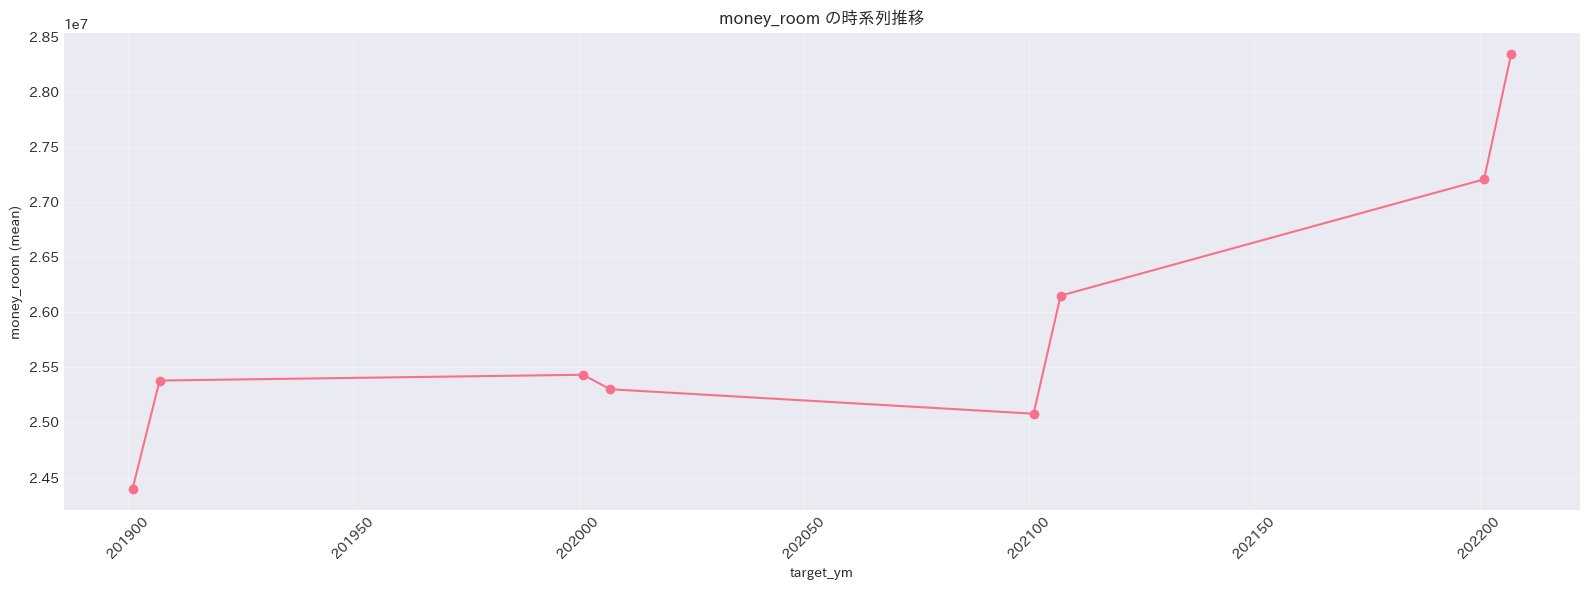

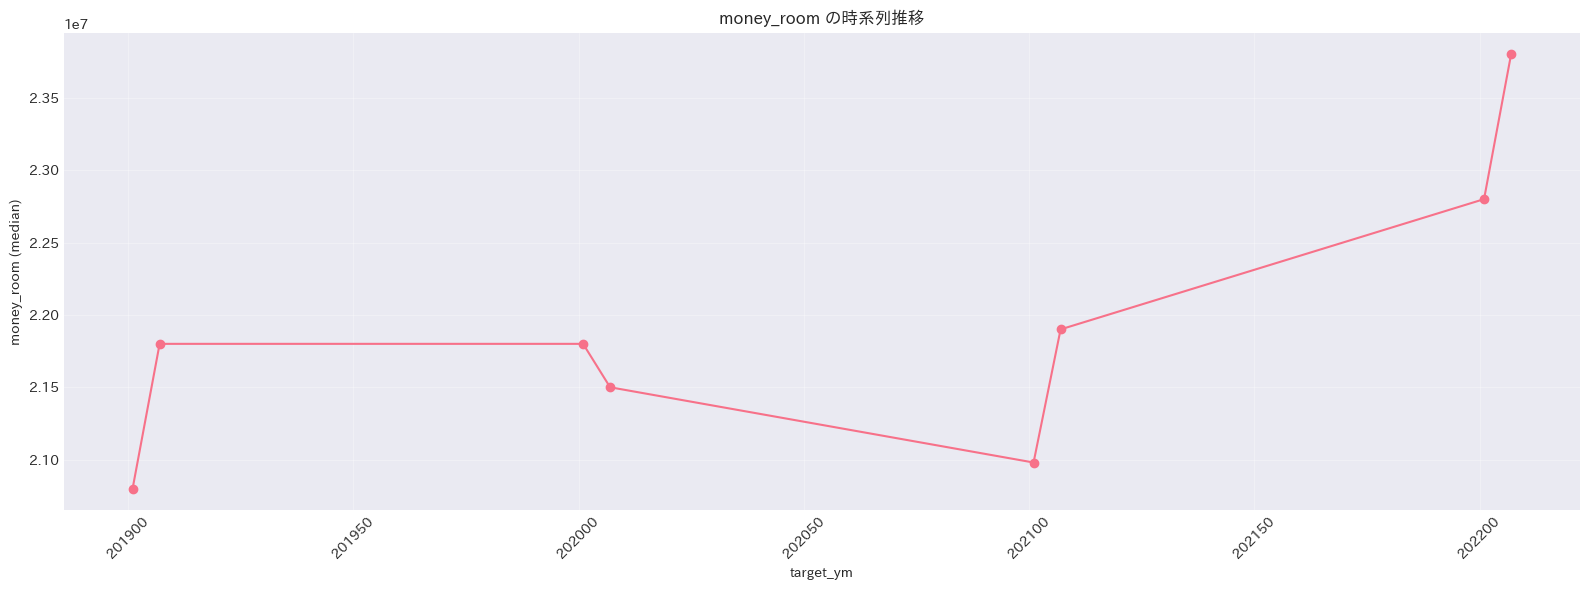

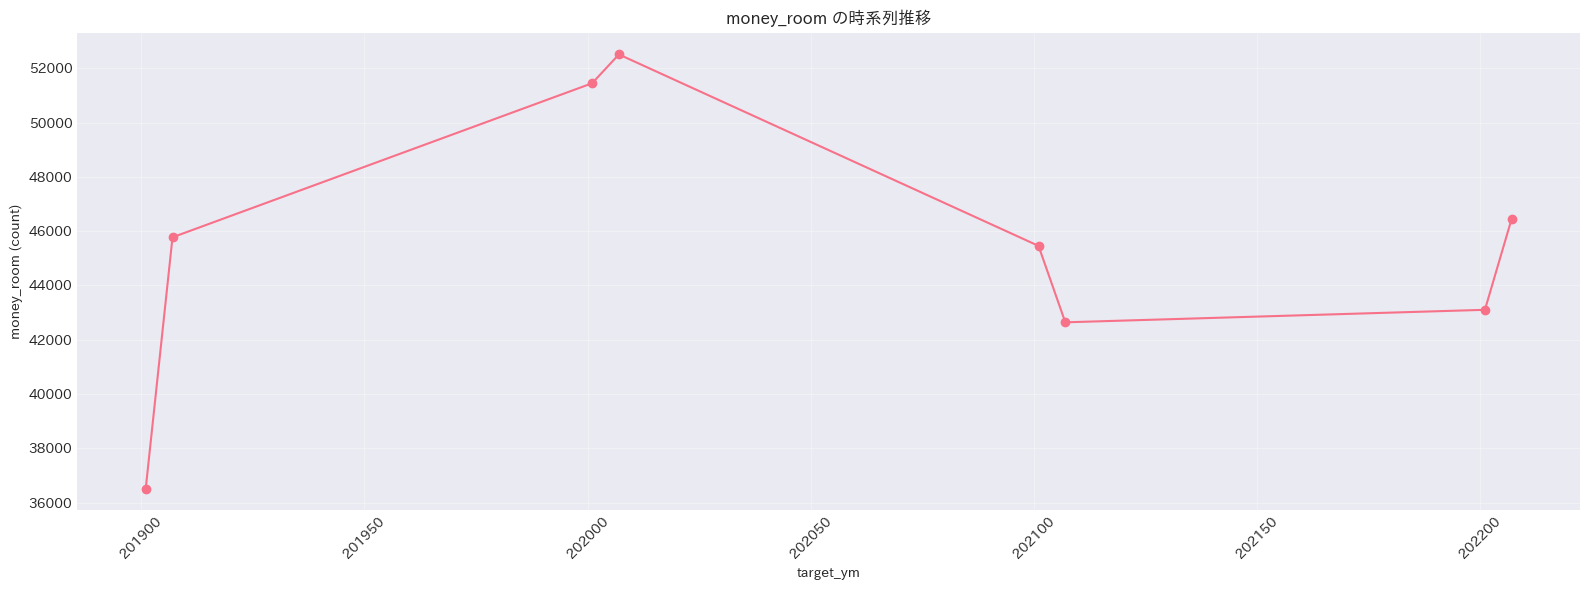

In [11]:
# 時系列カラムの確認
time_col = "target_ym"

if time_col in train.columns:
    # 月別の平均価格
    plot_time_series(train, time_col, target_col, agg_func="mean", figsize=(16, 6))
    
    # 月別の中央値
    plot_time_series(train, time_col, target_col, agg_func="median", figsize=(16, 6))
    
    # 月別のデータ件数
    plot_time_series(train, time_col, target_col, agg_func="count", figsize=(16, 6))
else:
    print(f"時系列カラム '{time_col}' が見つかりません")

## 6. 主要特徴量との関係性

**TODO**: 実際のデータで重要そうな特徴量を選んで分析

In [12]:
# 数値特徴量との相関を確認
# 欠損値が少なく、数値型のカラムを抽出
numerical_cols = [
    col for col, dtype in zip(train.columns, train.dtypes)
    if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                 pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                 pl.Float32, pl.Float64]
    and col != target_col
    and train[col].null_count() / train.height < 0.5  # 欠損50%未満
]

# 相関を計算（pandasを使用）
if len(numerical_cols) > 0:
    corr_with_target = (
        train.select([target_col] + numerical_cols[:50])  # 上位50カラムまで
        .to_pandas()
        .corr()[target_col]
        .drop(target_col)
        .sort_values(ascending=False)
    )
    
    print("[ターゲット変数との相関（上位20）]")
    print(corr_with_target.head(20))
    
    print("\n[ターゲット変数との相関（下位20）]")
    print(corr_with_target.tail(20))

[ターゲット変数との相関（上位20）]
year_built               0.332626
parking_money            0.308021
room_floor               0.295546
madori_kind_all          0.259677
room_kaisuu              0.244438
floor_count              0.223519
lon                      0.163669
el                       0.143111
management_form          0.140943
unit_count               0.133704
unit_area                0.108934
building_structure       0.096881
bukken_type              0.073227
target_ym                0.052891
usable_status            0.045436
building_type            0.035081
flg_new                  0.031581
building_status          0.020879
land_youseki             0.019037
snapshot_window_angle    0.015064
Name: money_room, dtype: float64

[ターゲット変数との相関（下位20）]
room_count            -0.007461
madori_number_all     -0.011104
parking_money_tax     -0.019559
flg_investment        -0.038813
land_kenpei           -0.044636
money_kyoueki_tax     -0.056123
parking_kubun         -0.071512
building_area_kind    

In [13]:
# 相関が高い特徴量の散布図（上位3件）
# top_corr_features = corr_with_target.head(3).index.tolist()

# for feature in top_corr_features:
#     plot_target_vs_feature(train, target_col, feature, figsize=(10, 6))

## 7. カテゴリ別のターゲット分布

**TODO**: 重要なカテゴリ変数を選んで分析

In [14]:
# カテゴリ変数（ユニーク数が適度に少ない）を選択
# categorical_cols = [
#     col for col in train.columns
#     if train[col].n_unique() <= 20
#     and train[col].n_unique() >= 2
#     and col != target_col
# ]

# # 例: カテゴリ別の箱ひげ図
# if len(categorical_cols) > 0:
#     sample_cat_col = categorical_cols[0]
#     
#     # Polarsでグループ化して統計量を取得
#     category_stats = (
#         train.group_by(sample_cat_col)
#         .agg([
#             pl.col(target_col).count().alias("count"),
#             pl.col(target_col).mean().alias("mean"),
#             pl.col(target_col).median().alias("median"),
#         ])
#         .sort("mean", descending=True)
#     )
#     
#     print(f"[{sample_cat_col} 別の統計量]")
#     print(category_stats)
#     
#     # 箱ひげ図（pandasに変換）
#     data_for_plot = train.select([sample_cat_col, target_col]).to_pandas()
#     
#     plt.figure(figsize=(12, 6))
#     data_for_plot.boxplot(column=target_col, by=sample_cat_col, figsize=(14, 6))
#     plt.suptitle("")
#     plt.title(f"{target_col} の分布（{sample_cat_col} 別）")
#     plt.xlabel(sample_cat_col)
#     plt.ylabel(target_col)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

## 8. ターゲット分析のまとめ

**ここに気づいた点をメモする**

### 分布の特徴
- 基本統計量: [メモ]
- 分布の形状: [正規分布 / 右歪 / 左歪 / 等]
- log変換の効果: [メモ]
- 外れ値の状況: [メモ]

### 時系列トレンド
- 時間的な傾向: [上昇 / 下降 / 季節性 / 等]
- データ件数の偏り: [メモ]

### 特徴量との関係
- 相関が高い特徴量: [リスト]
- カテゴリ別の傾向: [メモ]

### モデリングへの示唆
- [ ] ターゲット変数の変換（log変換など）の必要性
- [ ] 外れ値の処理方針
- [ ] 時系列を考慮したCV戦略
- [ ] 重要そうな特徴量の候補